# Visualizing learning in BigDL

In this example, we are going to use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) to train a [lenet-5](http://yann.lecun.com/exdb/lenet/) model, and visualize this training using jupyter and tensorboard.

In [1]:
import matplotlib
matplotlib.use('Agg')
%pylab inline

import datetime as dt
import tempfile

import sys
print(os.path.abspath(os.path.join('../neural_networks')))
sys.path.append(os.path.abspath(os.path.join('../neural_networks')))
from utils import get_mnist

from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from bigdl.dataset.transformer import *
from bigdl.dataset import mnist
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from pyspark import SparkContext
from IPython.display import Markdown, display

sc=SparkContext.getOrCreate(conf=create_spark_conf().setMaster("local[4]").set("spark.driver.memory","2g"))

init_engine()

Populating the interactive namespace from numpy and matplotlib
/home/xin/IntelAnalytics/BigDL-Tutorials2/notebooks/neural_networks


## 1. Train the network

* prepare training and validation samples

Please edit the "mnist_path" accordingly. If the "mnist_path" directory does not consist of the mnist data, mnist.read_data_sets method will download the dataset directly to the directory.

In [2]:
# Get and store MNIST into RDD of Sample, please edit the "mnist_path" accordingly.
mnist_path = "datasets/mnist"
(train_data, test_data) = get_mnist(sc, mnist_path)

print train_data.count()
print test_data.count()

('Extracting', 'datasets/mnist/train-images-idx3-ubyte.gz')
('Extracting', 'datasets/mnist/train-labels-idx1-ubyte.gz')
('Extracting', 'datasets/mnist/t10k-images-idx3-ubyte.gz')
('Extracting', 'datasets/mnist/t10k-labels-idx1-ubyte.gz')
60000
10000


* create the LeNet-5 model

In [3]:
# Create a LeNet model
def build_model(class_num):
    input = Reshape([1, 28, 28]).set_name("reshape_1_28_28")()
    conv1 = SpatialConvolution(1, 6, 5, 5).set_name("conv1_5x5")(input)
    tanh1 = Tanh().set_name("tanh1")(conv1)
    pool1 = SpatialMaxPooling(2, 2, 2, 2).set_name("pool1_2x2")(tanh1)
    tanh2 = Tanh().set_name("tanh2")(pool1)
    conv2 = SpatialConvolution(6, 12, 5, 5).set_name("conv2_5x5")(tanh2)
    pool2 = SpatialMaxPooling(2, 2, 2, 2).set_name("pool2_2x2")(conv2)
    reshape = Reshape([12 * 4 * 4]).set_name("reshape_192")(pool2)
    fc1 = Linear(12 * 4 * 4, 100).set_name("fc_192_100")(reshape)
    tanh3 = Tanh().set_name("tanh3")(fc1)
    fc2 = Linear(100, class_num).set_name("fc_100_" + str(class_num))(tanh3)
    output = LogSoftMax().set_name("classifier")(fc2)

    model = Model(input, output)
    return model
lenet_model = build_model(10)

creating: createReshape
creating: createSpatialConvolution
creating: createTanh
creating: createSpatialMaxPooling
creating: createTanh
creating: createSpatialConvolution
creating: createSpatialMaxPooling
creating: createReshape
creating: createLinear
creating: createTanh
creating: createLinear
creating: createLogSoftMax
creating: createModel


* configure optimizer

In [4]:
# Create an Optimizer

optimizer = Optimizer(
    model=lenet_model,
    training_rdd=train_data,
    criterion=ClassNLLCriterion(),
    optim_method=SGD(learningrate=0.4, learningrate_decay=0.0002),
    end_trigger=MaxEpoch(5),
    batch_size=256)

# Set the validation logic
optimizer.set_validation(
    batch_size=256,
    val_rdd=test_data,
    trigger=EveryEpoch(),
    val_method=[Top1Accuracy(), Loss()]
)

creating: createClassNLLCriterion
creating: createDefault
creating: createSGD
creating: createMaxEpoch
creating: createDistriOptimizer
creating: createEveryEpoch
creating: createTop1Accuracy
creating: createClassNLLCriterion
creating: createLoss


* Will create a TrainSummary and a ValSummary and set them to Optimizer to enable metrics collecting. By default, BigDL only collect throughput, loss, and validation result during the Training. We can use 
`train_summary.set_summary_trigger` to enable more metrics, like `Parameters` and `LearningRate`.

In [5]:
log_dir=tempfile.mkdtemp() # use a tmp folder
app_name='lenet-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
# create TrainSummary
train_summary = TrainSummary(log_dir=log_dir, app_name=app_name)
train_summary.set_summary_trigger("Parameters", SeveralIteration(50))
train_summary.set_summary_trigger("LearningRate", SeveralIteration(1))
# create ValSummary
val_summary = ValidationSummary(log_dir=log_dir, app_name=app_name)
# set TrainSummary and ValSummary to 
optimizer.set_train_summary(train_summary)
optimizer.set_val_summary(val_summary)

print "Will saving logs to",log_dir + "/" + app_name
display(Markdown("You can run shell command, **tensorboard --logdir=%s**, to visualize this training" % log_dir))

# Boot training process
trained_model = optimizer.optimize()
print "Optimization Done."

creating: createTrainSummary
creating: createSeveralIteration
creating: createSeveralIteration
creating: createValidationSummary
Will saving logs to /tmp/tmpvE6hzB/lenet-20180110-102403


You can run shell command, **tensorboard --logdir=/tmp/tmpvE6hzB**, to visualize this training

Optimization Done.


## 2. Visualization

* During the training, you can run tensorboard command showed below to visualize the training metrics, like LearningRate curve, Loss curve, and Paramters's histogram.

Run tensorboard command(tensorboard --logdir=/tmp/tmpvE6hzB, notice logdir will change in each run) to start tensorboard: 

![scalars](pictures/tb-start.png)

You can add command flag `--port` to use another port, if the defaut 6006 is unavailable.

Then, open your browser and type in TensorBoard's http address. From tensorboard's scalar tab, you can see the LearningRate curve and Loss curve like this:
![scalars](pictures/tb-scalars.png)

Open the DISTRIBUTIONS tab, you can see the learnable parameters' distribution during the training:
![distributions](pictures/tb-distributions.png)

* You can also use `Model.save_graph_topology` method to save graph's topology, and visualize the graph in TensorBoard.

In [6]:
lenet_model.save_graph_topology(log_dir + "/" + app_name + "/lenet-model")
print "Saving graph topology to", log_dir + "/" + app_name + "/lenet-model"

Saving graph topology to /tmp/tmpvE6hzB/lenet-20180110-102403/lenet-model


Open the graph tab in TensorBoard, you can see the model's topology:
![graph](pictures/tb-graph.png)

* BigDL also provide `read_scalar()` method to read scalar type metrics, like Loss and Top1Accuracy.
We can read training Loss, learning rate and Top1Accuracy, then draw three curves easily using matplotlib. 

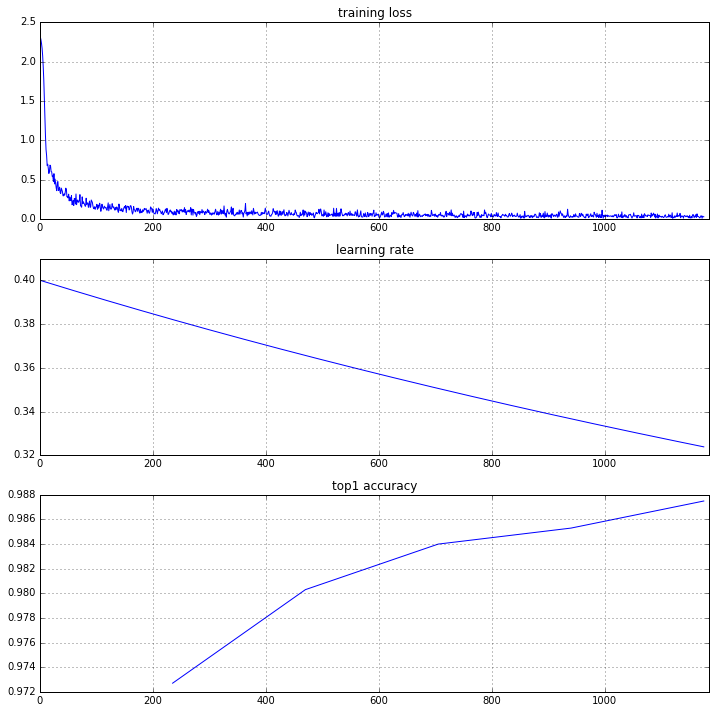

In [7]:
loss = np.array(train_summary.read_scalar("Loss"))
lr = np.array(train_summary.read_scalar("LearningRate"))
top1 = np.array(val_summary.read_scalar("Top1Accuracy"))

plt.figure(figsize = (12,12))
plt.subplot(3,1,1)
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("training loss")

plt.subplot(3,1,2)
plt.plot(lr[:,0],lr[:,1],label='lr')
plt.xlim(0,lr.shape[0]+10)
plt.title("learning rate")
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(top1[:,0],top1[:,1],label='top1')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("top1 accuracy")